# Running scVelo and CellRank using intestine-on-chip data

Figures 5 and S7

**Pre-requisites:**
- Dataset with QC-ed, pre-processed and clustered cells
- AnnData object with integrated loom files from velocyto (with spliced/unspliced RNA matrix)   

## Initial set-up

In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import scvelo as scv
import cellrank as cr

In [7]:
#AnnData object
anndata_with_loom_path = #path to folder where the AnnData object of the intestine-on-chip data is saved

## Calculate RNA velocity using scVelo 

In [5]:
# Load the data
adata = sc.read_h5ad(anndata_with_loom_path + 'intestine_on_chip_AnnData_with_Loom_media.h5ad')

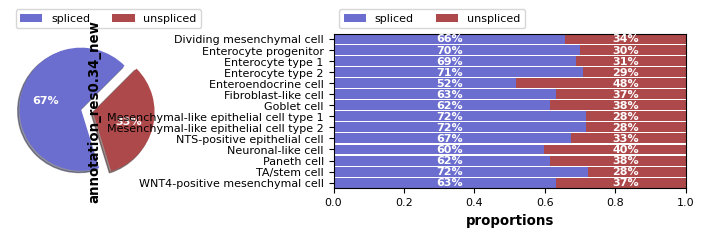

In [6]:
# Checking the proportions of spliced and unspliced mRNA
scv.pl.proportions(adata, groupby = 'annotation_res0.34_new')

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30)
scv.tl.recover_dynamics(adata, n_jobs = 4)

Filtered out 10747 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 4000 highly variable genes.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
#Compute velocity and the velocity graph
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata, n_jobs = 4)

computing velocities
    finished (0:00:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 4/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:54) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
#Change the cell type names to new annotation
#annotation_res0.34_new2
adata.obs['annotation_res0.34_new2'] = adata.obs['annotation_res0.34_new']

mapping = {'Paneth cell': 'Paneth-like cell', 'NTS-positive epithelial cell': 'Mesenchymal-like epithelial precursor', 'Dividing mesenchymal cell': 'Dividing mesenchymal/neural cell', 'Fibroblast-like cell': 'Myofibroblast', 'Neuronal-like cell': 'Neuron', 'WNT4-positive mesenchymal cell': 'WNT4-positive neural cell'} 
adata.obs['annotation_res0.34_new2'].replace(mapping, inplace=True)

#annotation_res0.34_simple2
adata.obs['annotation_res0.34_simple2'] = adata.obs['annotation_res0.34_simple']
mapping = {'Paneth cell': 'Paneth-like cell', 'NTS-positive epithelial cell': 'Mesenchymal-like epithelial cell', 'Dividing mesenchymal cell': 'Dividing mesenchymal/neural cell', 'Fibroblast-like cell': 'Myofibroblast', 'Neuronal-like cell': 'Neuron', 'WNT4-positive mesenchymal cell': 'WNT4-positive neural cell'} 
adata.obs['annotation_res0.34_simple2'].replace(mapping, inplace=True)


In [13]:
#Correction for differential kinects (necessary when different cell types are present in the dataset that might have different kinetic regimes)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='annotation_res0.34_new')

testing for differential kinetics
    finished (0:02:35) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


In [14]:
scv.get_df(adata[:, top_genes], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

fit_diff_kinetics  fit_pval_kinetics
AIG1                                     Enterocyte type 2           1.98e-05
FOXP1    Fibroblast-like cell,Goblet cell,Mesenchymal-l...           3.27e-03
FHOD3                                 Enteroendocrine cell           3.72e-06
TMEM45B                                  Enterocyte type 2           3.06e-03
IGDCC3                                  Neuronal-like cell           1.05e-03
...                                                    ...                ...
ADGRL3                                  Neuronal-like cell          1.13e-170
GUCY1A2           NTS-positive epithelial cell,Paneth cell           4.28e-07
CD47                        WNT4-positive mesenchymal cell           1.27e-34
ZNF462                                Fibroblast-like cell           2.15e-07
EDN1                                     Enterocyte type 2           2.70e-07

[194 rows x 2 columns]

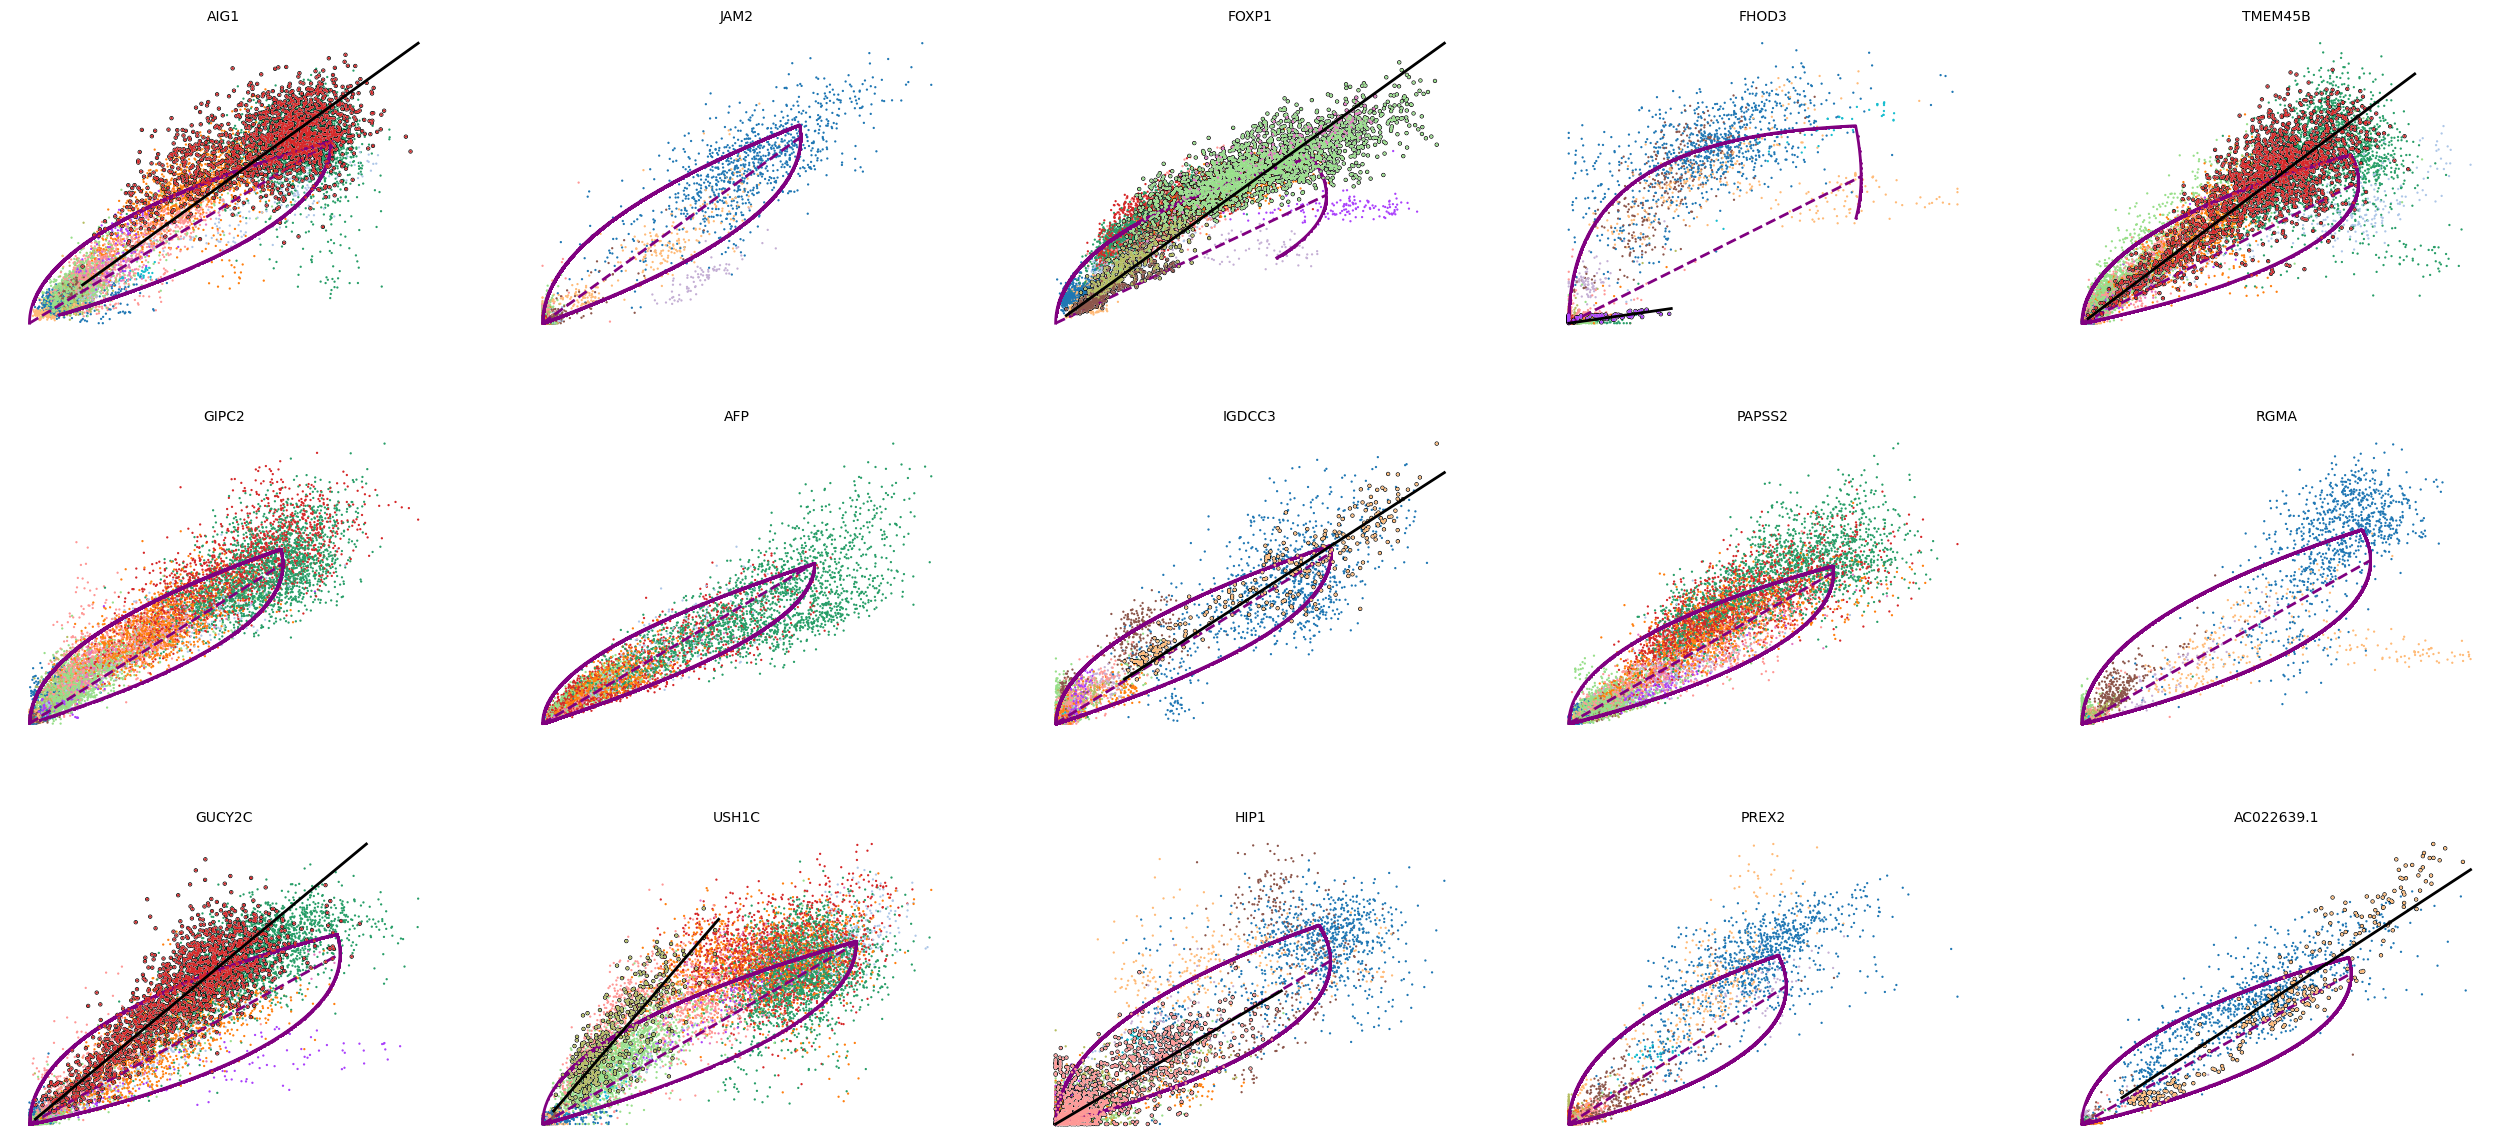

In [15]:
#Corrected models for top likelihood genes
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, add_outline='fit_diff_kinetics', **kwargs)

In [16]:
#Recompute the velocity based on the correction for differential kinects
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:01:58) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


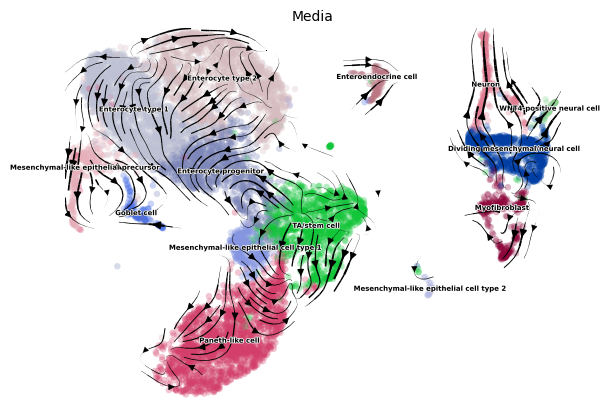

In [18]:
#New velocity embedding with corrected velocities
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=5, title="Media", min_mass=0, color = 'annotation_res0.34_new2')

In [38]:
#changing the colors in the annotation_res0.34_new2 annotation
#verify the order of the clusters in the adata object
adata.obs['annotation_res0.34_new2'].cat.categories

#change the order of the clusters in the adata object
adata.obs['annotation_res0.34_new2'] = adata.obs['annotation_res0.34_new2'].cat.reorder_categories(['TA/stem cell', 
                                                                                                    'Enterocyte progenitor', 
                                                                                                    'Enterocyte type 1', 
                                                                                                    'Enterocyte type 2',
                                                                                                    'Paneth-like cell',
                                                                                                    'Goblet cell',
                                                                                                    'Enteroendocrine cell',
                                                                                                   'Mesenchymal-like epithelial precursor',
                                                                                                   'Mesenchymal-like epithelial cell type 1',
                                                                                                   'Mesenchymal-like epithelial cell type 2',
                                                                                                   'Dividing mesenchymal/neural cell',
                                                                                                   'Myofibroblast',
                                                                                                   'Neuron',
                                                                                                   'WNT4-positive neural cell'])

#use the selected colors
ident_colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c', '#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#1b9e77','#d95f02','#7570b3','#e7298a']
#change the color annotation
adata.uns['annotation_res0.34_new2_colors']=ident_colours

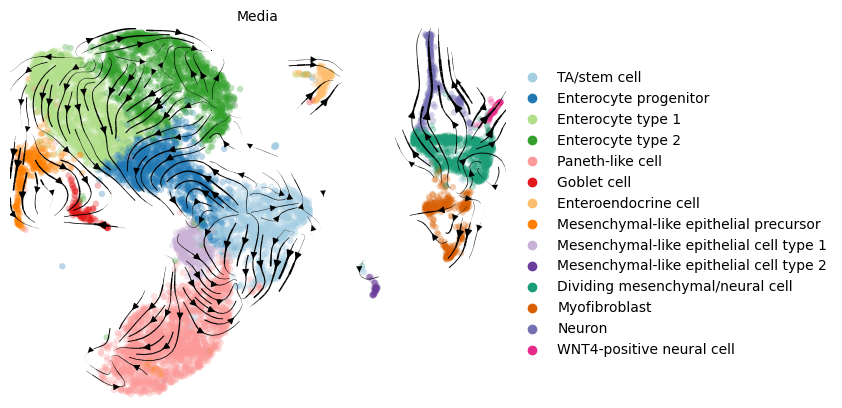

In [39]:
#Figure S7A: New velocity embedding with corrected velocities with annotation_res0.34_new2
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=10, legend_loc='right', title="Media", min_mass=0, color = 'annotation_res0.34_new2')

computing latent time using root_cells as prior
    finished (0:00:14) --> added 
    'latent_time', shared time (adata.obs)


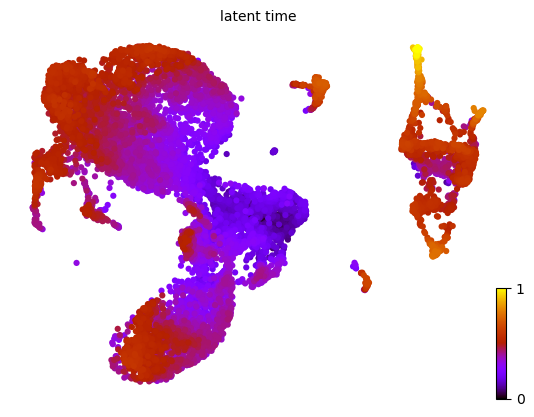

In [42]:
#Figure 5B: Generate latent time: approximates the real time experienced by cells as they differentiate
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [44]:
#Subset into compartments
adata_epithelial = adata[adata.obs['compartment_new'] == 'Epithelial cell']
adata_mesenchymal = adata[adata.obs['compartment_new'] == 'Mesenchymal cell']

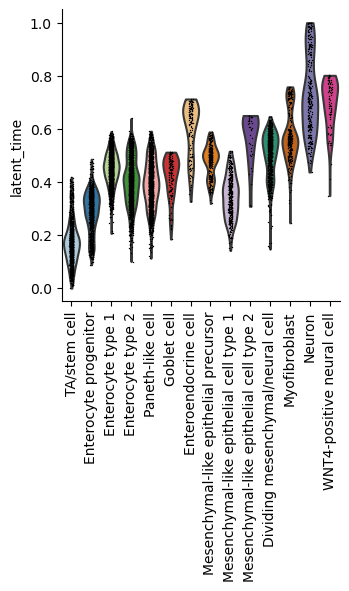

In [235]:
#Figure 5B: Generate violin plot of latent time
sc.pl.violin(adata, keys=["latent_time"], groupby="annotation_res0.34_new2", rotation=90, show=False)
    


In [67]:
# Generate table with probabilities of one celltype transitioning to another using PAGA integration
scv.tl.paga(adata, groups='annotation_res0.34_new2')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


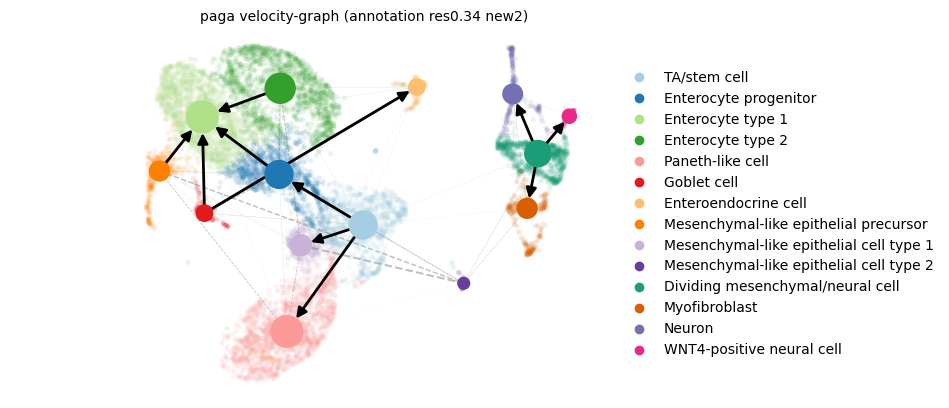

In [68]:
#Figure 5A: Integration RNA velocity and PAGA, directed PAGA plot
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

# Cellrank

In [80]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

100%|██████████████████████████████████| 11103/11103 [00:36<00:00, 303.37cell/s]


In [81]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=11103], initial_states=None, terminal_states=None]


In [82]:
g.compute_schur(n_components=20, method='brandts')

GPCCA[kernel=VelocityKernel[n=11103], initial_states=None, terminal_states=None]

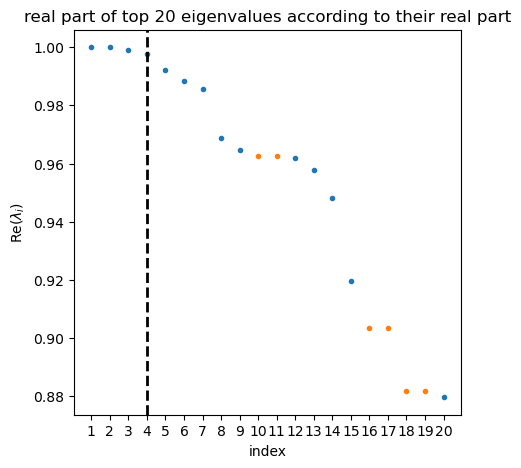

In [83]:
g.plot_spectrum(real_only=True)

In [84]:
#Select number of macrostates
g.compute_macrostates(n_states=8, cluster_key="annotation_res0.34_new2")

GPCCA[kernel=VelocityKernel[n=11103], initial_states=None, terminal_states=None]

/home/umcg-rmoerkens/.conda/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


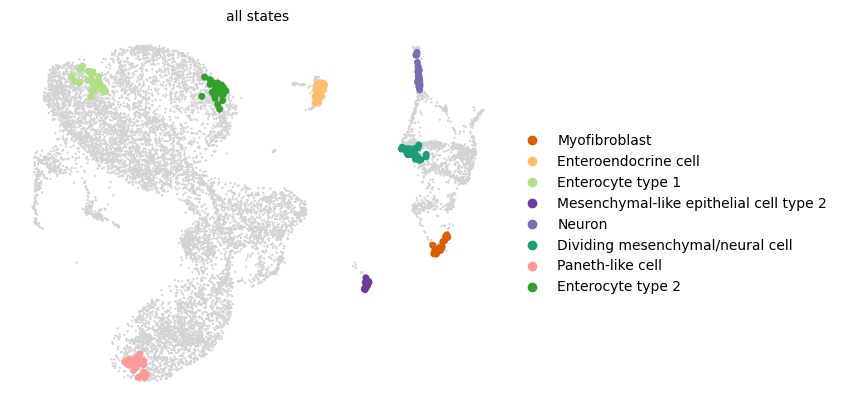

In [85]:
g.plot_macrostates(which="all", legend_loc="right", s=100)

In [92]:
#Decide which of the macrostates you identify as terminal state
g.set_terminal_states(states=["Myofibroblast", "Enteroendocrine cell", "Enterocyte type 1", "Mesenchymal-like epithelial cell type 2", "Neuron", "Paneth-like cell", "Enterocyte type 2"])

GPCCA[kernel=VelocityKernel[n=11103], initial_states=None, terminal_states=['Enterocyte type 1', 'Enterocyte type 2', 'Enteroendocrine cell', 'Mesenchymal-like epithelial cell type 2', 'Myofibroblast', 'Neuron', 'Paneth-like cell']]

100%|███████████████████████████████████████████████| 7/7 [00:41<00:00,  5.90s/]


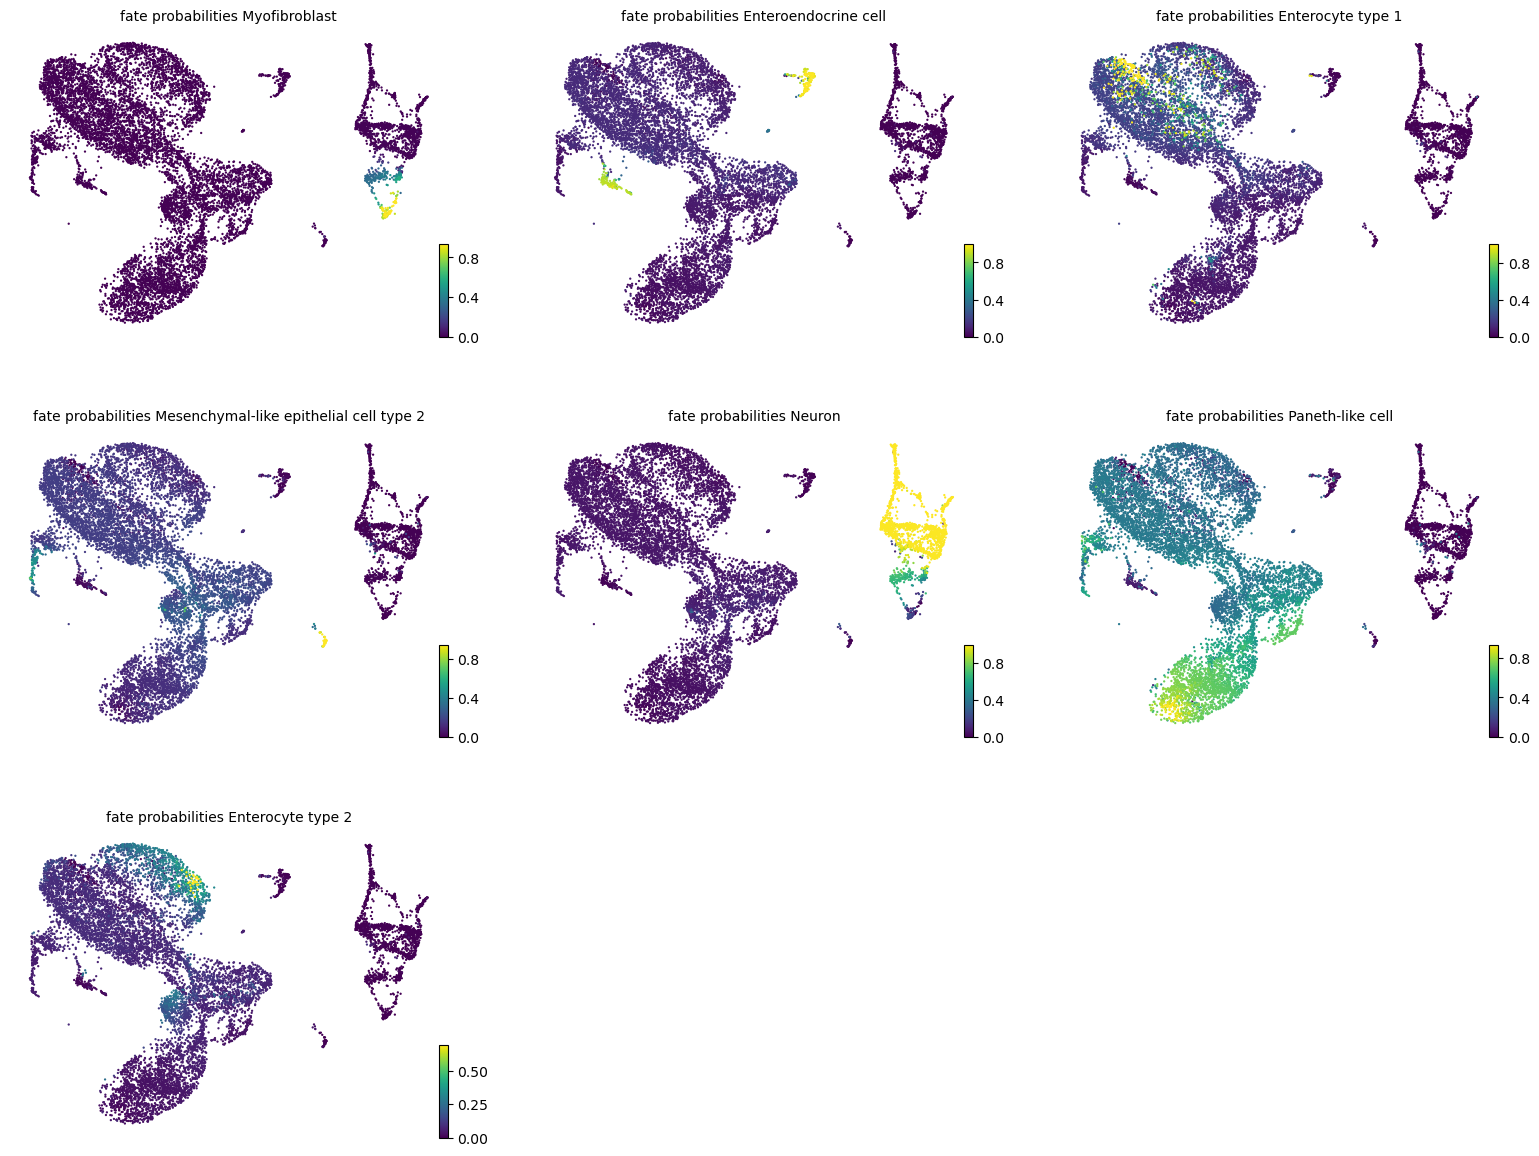

In [93]:
#Compute fate probabilities of all cells to a each terminal state
g.compute_fate_probabilities(use_petsc=False, n_jobs=4, solver='gmres')
g.plot_fate_probabilities(same_plot=False, ncols=3)

In [214]:
#calculate driver genes for specific trajectories
driver_genes = g.compute_lineage_drivers(
    lineages=["Enterocyte type 1"], cluster_key="annotation_res0.34_new2", clusters=['TA/stem cell', 'Enterocyte progenitor']
)
driver_genes.head(25)

#Restrict to specific clusters for each lineage based on fate probabilities:
#Enterocyte type 1: 'TA/stem cell', 'Enterocyte progenitor'
#Enterocyte type 2: 'TA/stem cell', 'Enterocyte progenitor', 'Enterocyte type 1'
#Paneth-like cell: all 
#Enteroendocrine cell: all
#Neuron: 'Dividing mesenchymal/neural cell'
#Myofibroblast: 'Dividing mesenchymal/neural cell', 'Mesenchymal-like epithelial cell type 2'
#Mesenchymal-like epithelial cell type 2: all

Enterocyte type 1_corr  Enterocyte type 1_pval  \
GSTA1                      0.44               3.02e-121   
FABP1                      0.42               1.59e-112   
TTR                        0.42               4.22e-111   
LGALS3                     0.42               4.67e-111   
APOA1                      0.42               3.51e-110   
TMEM256                    0.41               1.82e-107   
REEP6                      0.41               9.31e-105   
SELENOP                    0.40                3.23e-99   
AMN                        0.40                3.82e-98   
FTL                        0.39                4.82e-96   
TSPAN8                     0.39                4.73e-94   
S100A10                    0.38                1.66e-91   
GSTA2                      0.38                7.20e-91   
PRSS3                      0.38                1.69e-87   
DHRS11                     0.37                6.97e-84   
FTH1                       0.37                4.48e-83   
PHGR1                      0.36                4.60e-81   
MALL                       0.36                9.48e-81   
ANPEP                      0.36                2.13e-79   
TMEM45B                    0.35                1.33e-76   
VTN                        0.35                2.45e-76   
LGALS2                     0.35                8.05e-74   
CDX1                       0.35                2.67e-73   
DGAT1                      0.35                4.01e-73   
PRR13                      0.34                1.61e-71   

         Enterocyte type 1_qval  Enterocyte type 1_ci_low  \
GSTA1                 2.87e-118                      0.40   
FABP1                 7.55e-110                      0.39   
TTR                   1.48e-108                      0.39   
LGALS3                1.48e-108                      0.39   
APOA1                 9.53e-108                      0.39   
TMEM256               4.31e-105                      0.38   
REEP6                 1.96e-102                      0.38   
SELENOP                6.13e-97                      0.37   
AMN                    6.60e-96                      0.36   
FTL                    7.63e-94                      0.36   
TSPAN8                 6.90e-92                      0.36   
S100A10                2.11e-89                      0.35   
GSTA2                  8.55e-89                      0.35   
PRSS3                  1.69e-85                      0.34   
DHRS11                 6.30e-82                      0.34   
FTH1                   3.86e-81                      0.33   
PHGR1                  3.64e-79                      0.33   
MALL                   7.20e-79                      0.33   
ANPEP                  1.56e-77                      0.33   
TMEM45B                9.04e-75                      0.32   
VTN                    1.60e-74                      0.32   
LGALS2                 4.78e-72                      0.31   
CDX1                   1.49e-71                      0.31   
DGAT1                  2.17e-71                      0.31   
PRR13                  8.28e-70                      0.31   

         Enterocyte type 1_ci_high  
GSTA1                         0.47  
FABP1                         0.45  
TTR                           0.45  
LGALS3                        0.45  
APOA1                         0.45  
TMEM256                       0.45  
REEP6                         0.44  
SELENOP                       0.43  
AMN                           0.43  
FTL                           0.43  
TSPAN8                        0.42  
S100A10                       0.42  
GSTA2                         0.42  
PRSS3                         0.41  
DHRS11                        0.40  
FTH1                          0.40  
PHGR1                         0.40  
MALL                          0.40  
ANPEP                         0.39  
TMEM45B                       0.39  
VTN                           0.39  
LGALS2                        0.38  
CDX1                          0.38  

In [125]:
adata.obs["fate_probabilities_enterocyte_type_1"] = g.fate_probabilities["Enterocyte type 1"].X.flatten()
adata.obs["fate_probabilities_enterocyte_type_2"] = g.fate_probabilities["Enterocyte type 2"].X.flatten()
adata.obs["fate_probabilities_paneth"] = g.fate_probabilities["Paneth-like cell"].X.flatten()
adata.obs["fate_probabilities_enteroendocrine"] = g.fate_probabilities["Enteroendocrine cell"].X.flatten()
adata.obs["fate_probabilities_neuron"] = g.fate_probabilities["Neuron"].X.flatten()
adata.obs["fate_probabilities_myofibroblast"] = g.fate_probabilities["Myofibroblast"].X.flatten()
adata.obs["fate_probabilities_mesenchymal_like_epithelial_cell_2"] = g.fate_probabilities["Mesenchymal-like epithelial cell type 2"].X.flatten()

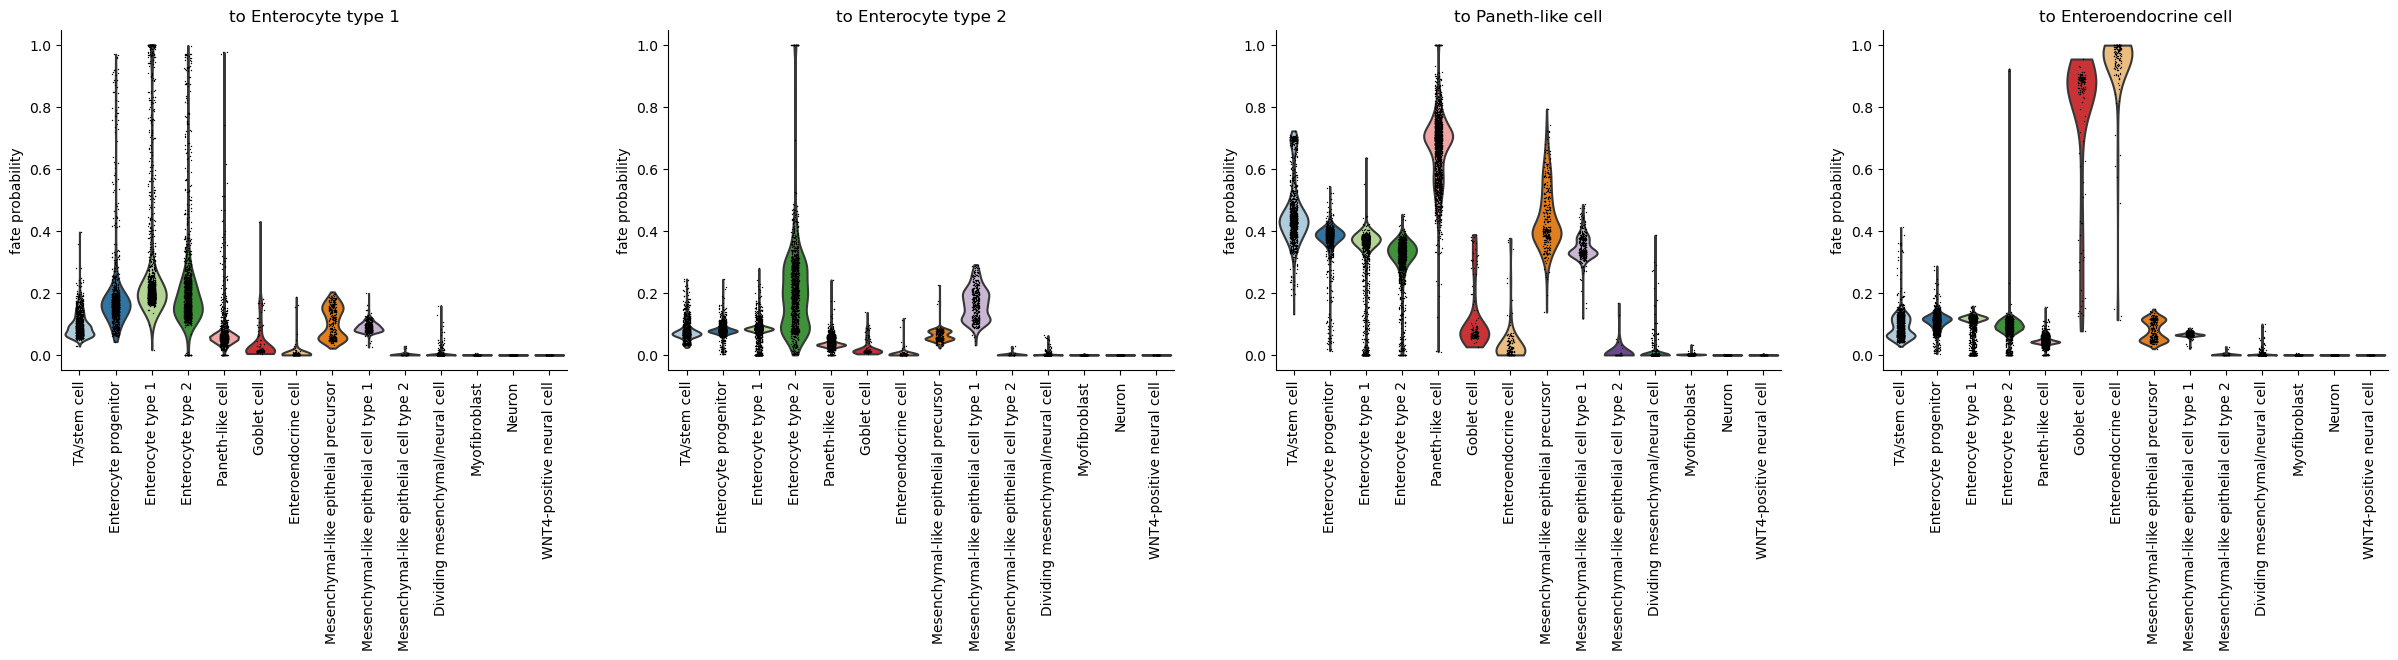

In [149]:
# Figure 5D and S7B: Aggregate fate probabilities - show what is the fate commitment of a group of cells
# We visualize how fate-commited each of these populations is towards a given lineage
cr.pl.aggregate_fate_probabilities(
    adata,
    mode='violin',
    lineages=['Enterocyte type 1', 'Enterocyte type 2', 'Paneth-like cell', 'Enteroendocrine cell'],
    cluster_key='annotation_res0.34_new2',
    ncol=3
)

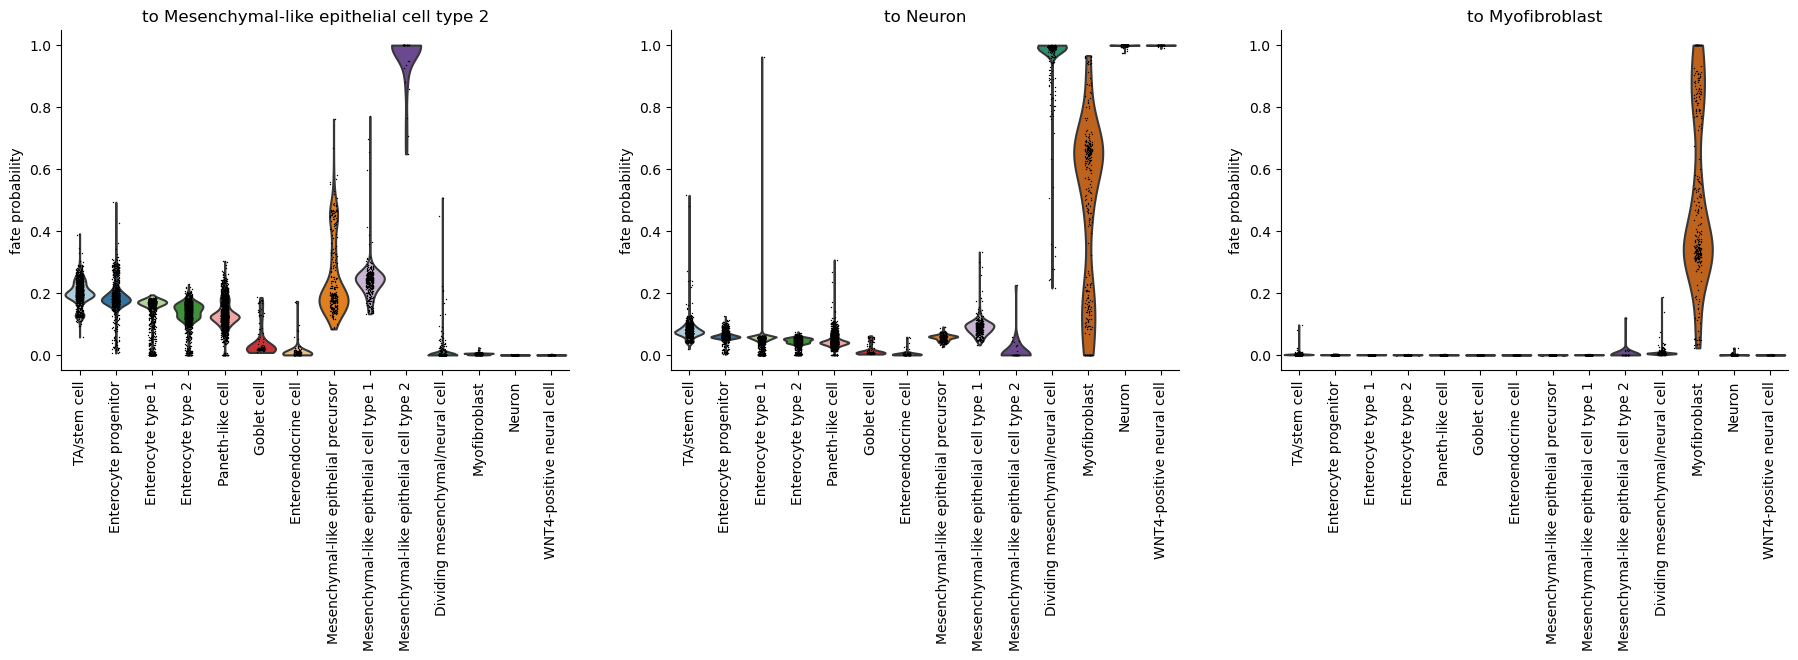

In [147]:
# Figure 5D and S7B: Aggregate fate probabilities - show what is the fate commitment of a group of cells
# We visualize how fate-commited each of these populations is towards a give lineage
cr.pl.aggregate_fate_probabilities(
    adata,
    mode='violin',
    lineages=['Mesenchymal-like epithelial cell type 2', 'Neuron', 'Myofibroblast'],
    cluster_key='annotation_res0.34_new2',
    ncol=3
)

In [130]:
#MAGIC imputation
import palantir

# Diffusion map
dm_res = palantir.utils.run_diffusion_maps(adata)
imp_df = palantir.utils.run_magic_imputation(adata, dm_res)

#save imputed data
adata.layers['magic_imputed_data'] = imp_df

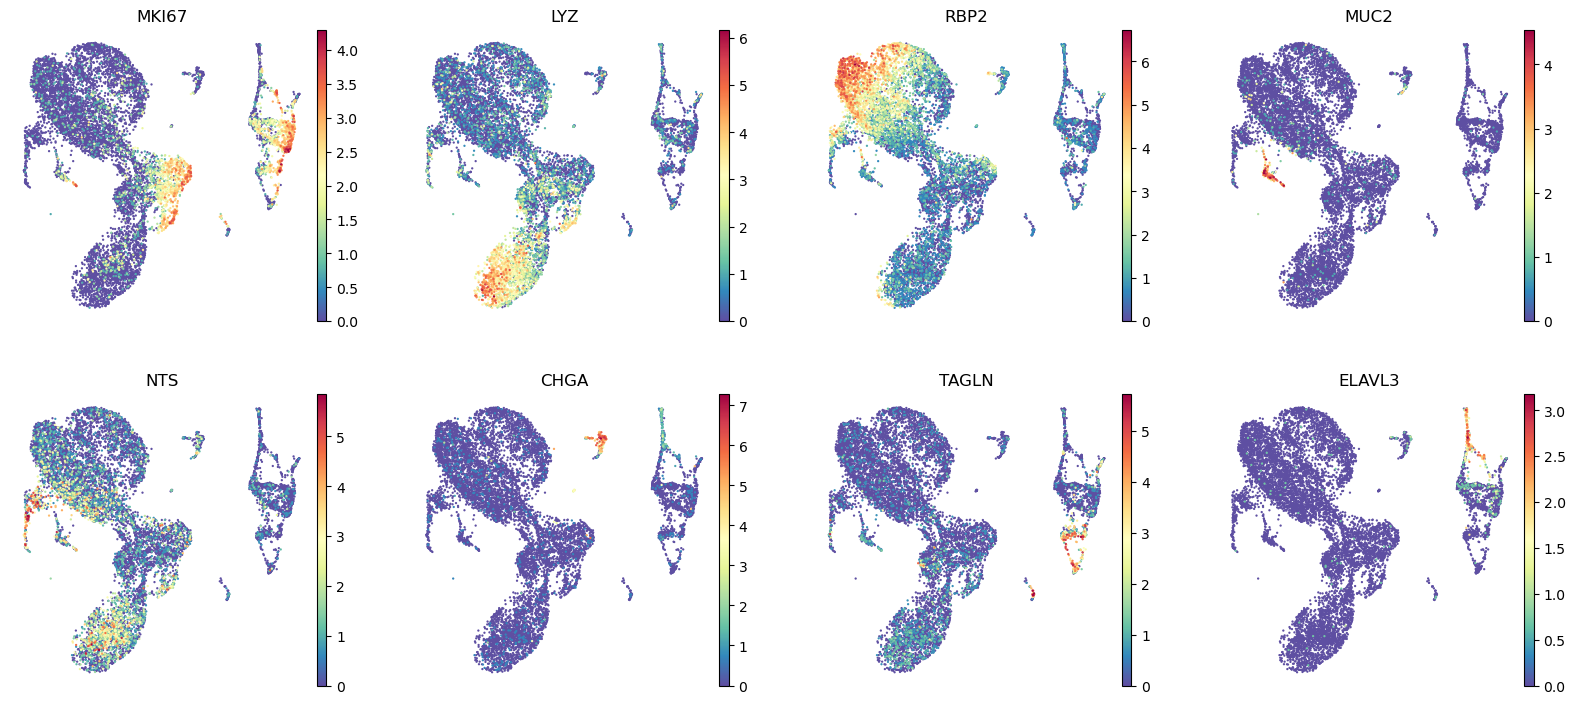

In [134]:
# Checking expression of some marker genes after the imputation
sc.pl.umap(adata, color=['MKI67', 'LYZ', 'RBP2', 'MUC2', 'NTS', 'CHGA', 'TAGLN', 'ELAVL3'], frameon=False)

In [159]:
#Activate model to plot the driver genes along latent_time
model = cr.models.GAM(adata, n_knots=6)

In [200]:
#Subset into compartments 
adata_epithelial = adata[adata.obs['compartment_new'] == 'Epithelial cell']
adata_mesenchymal = adata[adata.obs['compartment_new'] == 'Mesenchymal cell']

100%|█████████████████████████████████████████| 40/40 [00:03<00:00, 10.64gene/s]


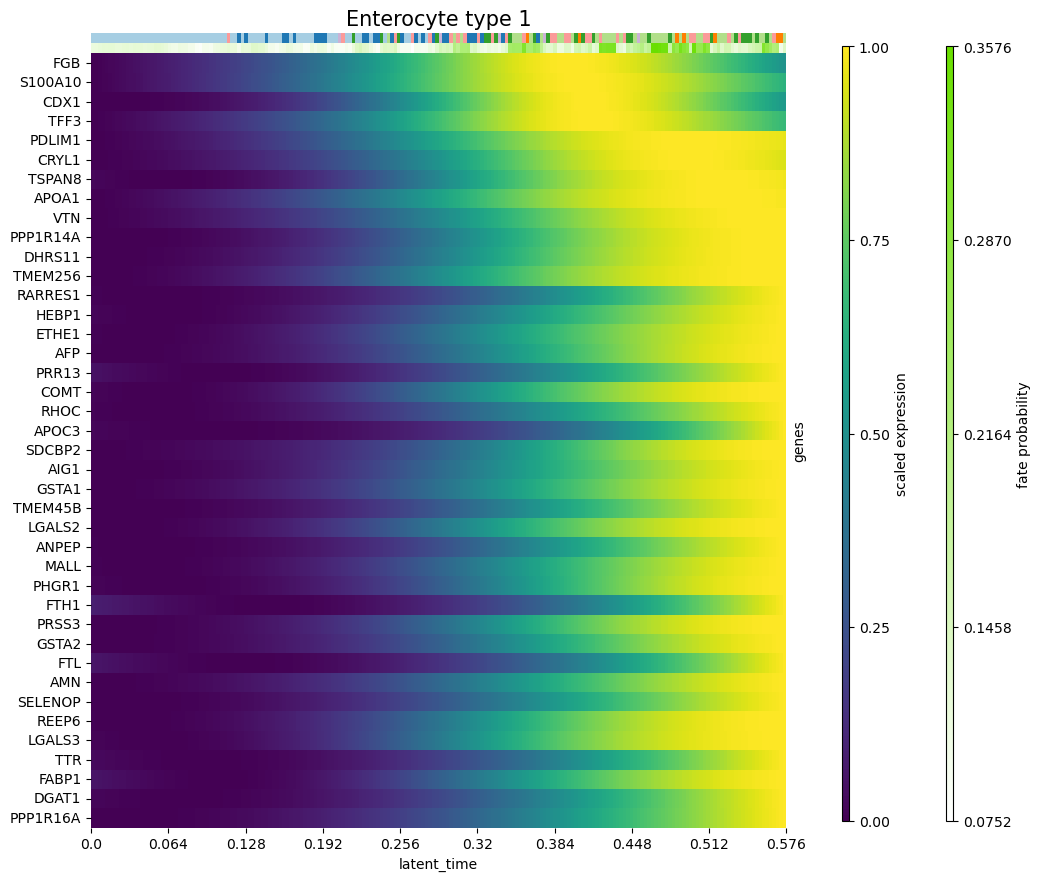

In [209]:
#Figure 5C and 5E: Plot driver genes along respective latent_time trajectory

driver_genes = g.compute_lineage_drivers(
    lineages=["Enterocyte type 1"], cluster_key="annotation_res0.34_new2", clusters=['TA/stem cell', 'Enterocyte progenitor']
)

#Restrict to specific clusters for each lineage based on fate probabilities:
#Enterocyte type 1: 'TA/stem cell', 'Enterocyte progenitor'
#Enterocyte type 2: 'TA/stem cell', 'Enterocyte progenitor', 'Enterocyte type 1'
#Paneth-like cell: all 
#Enteroendocrine cell: all
#Mesenchymal-like epithelial cell type 2: all
#Neuron: 'Dividing mesenchymal/neural cell'
#Myofibroblast: 'Dividing mesenchymal/neural cell', 'Mesenchymal-like epithelial cell type 2'

# plot heatmap
#Data key = 'magic_imputed_data' uses the magic imputation
#For epithelial cell types use adata_epithelial subsetted object
#For mesenchymal/neural cell types use adata_mesenchymal subsetted object
cr.pl.heatmap(
    adata_epithelial,
    model=model,  
    lineages="Enterocyte type 1",
    cluster_key="annotation_res0.34_new2",
    show_fate_probabilities=True,
    data_key="magic_imputed_data",
    genes=driver_genes.head(40).index,
    time_key="latent_time",
    figsize=(10, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
    fontsize=15
)